# ML-7. Оптимизация гиперпараметров модели. Практическое задание.

In [175]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

%matplotlib inline
plt.style.use('seaborn')

# Задание

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

## Данные

Данные представлены в формате CSV.  Каждая строка представляет молекулу. 

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];

Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.




## Знакомство с данными и их исследование

In [176]:
#ЕСЛИ РАБОТАЕМ В IDE
#data = pd.read_csv('data/adult.csv')

#ЕСЛИ РАБОТАЕМ В GOOGLE COLAB
# подключаем google диск, где у нас хранятся данные
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [177]:
# берем необходимый нам файл с диска, указав путь
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/_train_sem09 (1).csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


Проверяем наличие пропусков

Смотрим на сбалансированность классов:

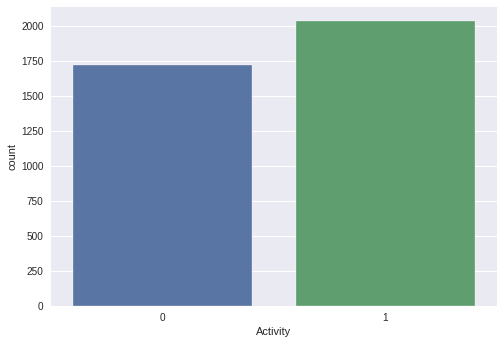

In [178]:
sns.countplot(data=data, x='Activity');

Целевой признак сбалансирован, стратифицированное разбиение необязательно.

In [179]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

Разделяем выборку на тренировочную и тестовую в соотношении 70/30. 

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 88, test_size = 0.3)

#<center> ОПТИМИЗАЦИЯ ПАРАМЕТРОВ ГИПЕРПАРАМЕТРОВ

# Default Логистическая регрессия 

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [229]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


# GridSearchCV Логистическая регрессия

In [232]:
#Словарь с именами гиперпараметров в качестве ключей и списками параметров в качестве значений.
param_grid = {'penalty': [ 'l1', 'l2', 'none'] ,#тип регуляризации
              'solver': ['liblinear', 'newton-cg'], #алгоритм оптимизации
              }
grid_search = GridSearchCV(
    #алгоритм, который будем оптимизировать
    estimator=linear_model.LogisticRegression(
        random_state=88, #генератор случайных чисел
        max_iter=50 #количество итераций на сходимость
    ), 
    param_grid=param_grid, 
    #количество фолдов в кросс-валидации
    cv=5, 
    # количество ядер для распараллеливания расчёта. 
    #-1 использует все существующие ядра
    n_jobs = -1
)  
%time grid_search.fit(X_train, y_train) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning:


10 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

CPU times: user 1.52 s, sys: 204 ms, total: 1.73 s
Wall time: 1min 41s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'liblinear'}


Значения метрик не изменились, но это значит лишь, что мы не нашли комбинацию внешних параметров лучше, чем заданы по умолчанию. Это не удивительно и достаточно часто исходные  гиперпараметры дают неплохой результат, но это не повод останавливаться.

**Попробуем расширить сетку гиперпараметров.**

In [233]:
param_grid = [
              {'penalty': ['l2', 'none'] , # тип регуляризации
              'solver': ['lbfgs', 'sag'], # алгоритм оптимизации
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}, # уровень силы регурялизации
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_1 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=1, max_iter=50), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_1.fit(X_train, y_train) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_1.best_params_))

CPU times: user 8.3 s, sys: 400 ms, total: 8.7 s
Wall time: 5min 43s
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'C': 0.3, 'penalty': 'l1', 'solver': 'saga'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



Метрику опять не удалось улучшить, 


Ознакомиться с итоговой полученной моделью можно с помощью best_estimator_. 

In [184]:
print("Наилучшая модель:\n{}".format(grid_search.best_estimator_))

Наилучшая модель:
LogisticRegression(max_iter=500, penalty='l1', random_state=88,
                   solver='liblinear')


А наилучшее значение точности кросс-валидации (значение точности, усредненное по всем разбиениям для данной комбинации гиперпараметров) – в атрибуте best_score_. 

**не путайте best_score_ со значением точности модели, которое вычисляется на тестовом наборе с помощью метода score. Метод score (оценивающий качество результатов, полученных с помощью метода predict) использует модель, построенную на всем обучающем наборе данных. В атрибуте best_score_ записывается средняя точность кросс-валидации. Для ее вычисления используется модель, построенная на обучающем наборе кросс-валидации.

In [185]:
print("Наилучшее значение точности при кросс-валидаци: {:.2f}".format(grid_search.best_score_))

Наилучшее значение точности при кросс-валидаци: 0.75


In [186]:
# Взглянем на результаты кросс-валидации
result_cv = pd.DataFrame(grid_search_1.cv_results_)
result_cv.head(2)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_penalty,param_solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.654801,0.115430,0.029516,0.002712,0.01,l2,lbfgs,"{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}",0.739048,0.739048,0.748571,0.780952,0.740952,0.749714,0.016009,13
1,5.889909,0.456676,0.032766,0.009644,0.01,l2,sag,"{'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}",0.739048,0.740952,0.748571,0.780952,0.740952,0.750095,0.015772,11


In [187]:
result_cv.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_penalty', 'param_solver', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'split3_test_score', 'split4_test_score', 'mean_test_score',
       'std_test_score', 'rank_test_score'],
      dtype='object')

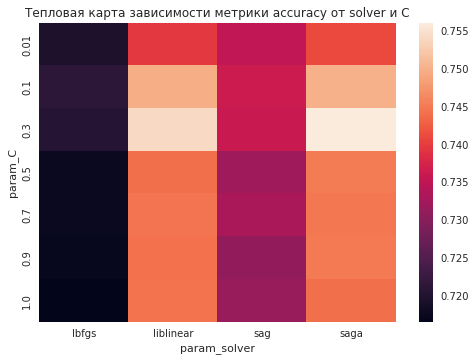

In [188]:
# отрисуем, как менялась точность при различных гиперпараметрах
visual = pd.pivot_table(pd.DataFrame(grid_search_1.cv_results_),
                        values='mean_test_score', index='param_C',
                        columns='param_solver')
sns.heatmap(visual)
plt.title('Тепловая карта зависимости метрики accuracy от solver и С') # подпись графика
sns.set(rc={'figure.figsize':(12, 8)}) #задаем размер графика

Видим, что лучшая регуляризация С = 0,3 положительно влияет на метрику.

#RandomizedSearchCV Логистическая регрессия

In [189]:


#np.linspace(start(от), stop(до), num=50(количество),dtype- тип данных)
param_distributions = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=88, max_iter=1000), 
    param_distributions=param_distributions, 
    cv=5, 
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search.fit(X_train, y_train) 
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search.best_params_))

CPU times: user 7.04 s, sys: 872 ms, total: 7.91 s
Wall time: 8min 58s
f1_score на тестовом наборе: 0.78
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.34}


За 10 итераций метрику улучшить не удалось, но обратите внимание на время. Давайте зададим аналогичную сетку и проделаем тоже с помощью GridSearchCV и сравним:

In [190]:
param_grid = {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 10, 10, dtype=float))},
            
grid_search_2 = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=1000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_2.fit(X_train, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_2.score(X_test, y_test)))
y_test_pred = grid_search_2.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_2.best_params_))

CPU times: user 24.5 s, sys: 2.42 s, total: 27 s
Wall time: 57min 5s
accuracy на тестовом наборе: 0.77
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}


# Default Случайный лес

Проделаем аналогичное для RandomForestClassifier().
Сначала посчитаем модель с параметрами по умолчанию и оценим метрику:

In [231]:
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=42)

#Обучаем модель
rf.fit(X_train, y_train)
#Выводим значения метрики 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 1.00
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82


Теперь зададим сетку гиперпараметров: 

*   'n_estimators' - количество деревьев в лесу, по умолчанию =100

*  'min_samples_leaf' - минимальное количество объектов в листе;
*  'max_depth': максимальная глубина дерева, не должна быть слишком большой, иначе будет переобучение

#RandomizedSearchCV Случайный лес

In [192]:
param_distributions = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    cv=5,
    n_iter = 10, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(random_search_forest.score(X_test, y_test)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 2.45 s, sys: 79.4 ms, total: 2.53 s
Wall time: 48.7 s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 28}


#GridSearchCV Случайный лес

In [193]:
param_grid = {'n_estimators': list(range(80, 200, 30)),
              'min_samples_leaf': [5],
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_forest.score(X_test, y_test)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 3.09 s, sys: 107 ms, total: 3.2 s
Wall time: 1min 39s
f1_score на обучающем наборе: 0.94
accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 140}


Метрику удалось еще больше улучшить с помощью обоих методов, но RandomizedSearchCV опять же потребовалось в два раза меньше времени;

Вывод по базовой оптимизации:
На множестве примеров нам удалось продемонстрировать более эффективную и быструю работу RandomizedSearchCV над GridSearchCV.

#Hyperopt Случайный лес

In [194]:
# Устанавливаем библиотеку
!pip install hyperopt
# или
#!conda install -c conda-forge hyperopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [195]:
#делаем импорт и выведем версию библиотеки
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
# fmin - основная функция, она будет минимизировать наш функционал
# tpe - алгоритм оптимизации
# hp - включает набор методов для объявления пространства поиска гиперпараметров
# trails - используется для логирования результатов

print("Версия Hyperopt : {}".format(hyperopt.__version__))

Версия Hyperopt : 0.2


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [196]:
# зададим пространство поиска гиперпараметров
space={'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
       'max_depth' : hp.quniform('max_depth', 15, 26, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

Интерфейс hyperopt отличается от Grid или RandomizedSearch, поэтому нам нужно создать функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [197]:
# зафксируем random_state
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    # используем эту комбинацию для построения модели
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    # обучаем модель
    model.fit(X, y)
    #применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [198]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:57<00:00,  2.87s/it, best loss: -0.9884251139950895]
Наилучшие значения гиперпараметров {'max_depth': 24.0, 'min_samples_leaf': 2.0, 'n_estimators': 153.0}
CPU times: user 48.7 s, sys: 119 ms, total: 48.8 s
Wall time: 57.4 s


In [199]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

Для байесовских оптимизаторов это возможно, так как они ориентируются на прошлые результаты: предыдущие входные данные для целевой функции и результирующие потери.

Hyperopt продолжит поиск с того места, где он остановился, если мы передадим ему объект Trials, который уже содержит информацию о предыдущих запусках.

Всегда сохраняйте свои предыдущие результаты.

In [200]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 3/3 [00:09<00:00,  3.21s/it, best loss: -0.9894736842105263]
Наилучшие значения гиперпараметров {'max_depth': 22.0, 'min_samples_leaf': 2.0, 'n_estimators': 126.0}


Видим, что Hyperot смог улучшить нашу метрику, причем за меньшее время.

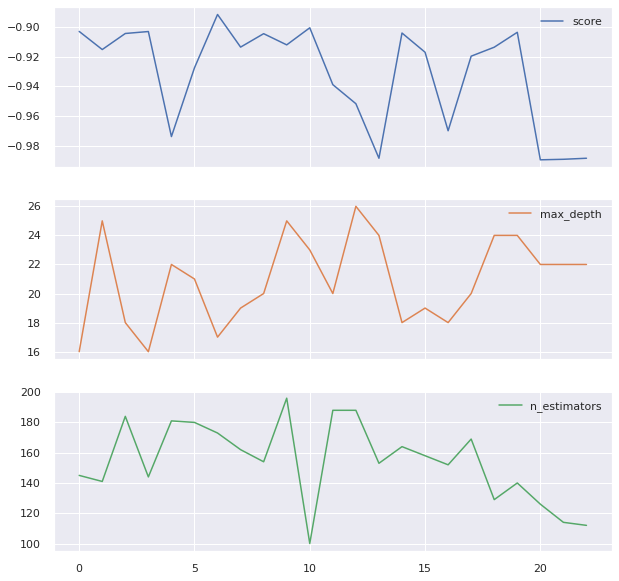

In [201]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10));

По графикам видно, что лучшая точность достигается именно в best_params. Но заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как,  hyperopt может только минимизировать.

# Hyperopt Логистическая регрессия

In [202]:
# зададим пространство поиска гиперпараметров
#Словарь с именами гиперпараметров в качестве ключей и списками параметров в качестве значений.
space={'penalty': hp.choice(label='penalty', options=['l2', 'none']),
       'solver' : hp.choice(label='solver', options=['lbfgs', 'sag']),
       'C': hp.choice(label='C', options=list(np.linspace(0.01, 1, 10, dtype=float)))
      }

Создаем функцию для минимизации, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.

In [203]:
# зафиксируем random_state
random_state = 88
def hyperopt_rf(space, cv=5, X=X_train, y=y_train, random_state=random_state):

    # используем эту комбинацию для построения модели
    model = linear_model.LogisticRegression(
       **space,
        random_state=random_state,
        max_iter=50
    )
    # обучаем модель
    model.fit(X, y)
    
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [204]:
# начинаем подбор гиперпараметров
%%time

trials = Trials() # используется для логирования результатов

best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=20, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )


  5%|▌         | 1/20 [00:00<00:18,  1.05it/s, best loss: -0.8185567010309278]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters




 10%|█         | 2/20 [00:07<01:15,  4.21s/it, best loss: -0.8831078737426292]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters




 15%|█▌        | 3/20 [00:13<01:26,  5.10s/it, best loss: -0.8831078737426292]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 20%|██        | 4/20 [00:14<00:55,  3.47s/it, best loss: -0.896744837241862] 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 25%|██▌       | 5/20 [00:19<01:01,  4.13s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 30%|███       | 6/20 [00:20<00:43,  3.10s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 35%|███▌      | 7/20 [00:21<00:29,  2.28s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 40%|████      | 8/20 [00:22<00:20,  1.71s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters




 45%|████▌     | 9/20 [00:24<00:22,  2.01s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 50%|█████     | 10/20 [00:27<00:21,  2.20s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 55%|█████▌    | 11/20 [00:29<00:20,  2.32s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 60%|██████    | 12/20 [00:30<00:14,  1.77s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters




 65%|██████▌   | 13/20 [00:33<00:14,  2.03s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge




 70%|███████   | 14/20 [00:33<00:09,  1.58s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters




 75%|███████▌  | 15/20 [00:34<00:06,  1.27s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 80%|████████  | 16/20 [00:34<00:04,  1.05s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 85%|████████▌ | 17/20 [00:35<00:02,  1.13it/s, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters




 90%|█████████ | 18/20 [00:37<00:02,  1.42s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters




 95%|█████████▌| 19/20 [00:38<00:01,  1.16s/it, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




100%|██████████| 20/20 [00:38<00:00,  1.95s/it, best loss: -0.896744837241862]
CPU times: user 35.2 s, sys: 3.39 s, total: 38.6 s
Wall time: 39 s


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




In [205]:
from hyperopt import space_eval
s = space_eval(space, best)
print(f'Наилучшие значения гиперпараметров {s}')


Наилучшие значения гиперпараметров {'C': 1.0, 'penalty': 'none', 'solver': 'lbfgs'}


Я так понял, что при этих параметрах достигнут лучший уровень f1-score равный 0.896744837241862 на всей выборке

In [206]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(
    random_state=random_state, 
    penalty = s['penalty'],
    solver = s['solver'],
    C = s['C']
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.93
f1_score на тестовом наборе: 0.77


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Обучили модель на лучших гиперпараметрах {'C':1, 'penalty': 'l2', 'solver': 'lbfgs'}и теперь нашли метрику f1-score на обучающих и тестовых данных 

Мы можем продолжить поиск гиперпараметров, чтобы получить лучшие результаты.

In [207]:
# если необходимо продолжить подбор, 
# то увеличиваем max_evals(должен быть строго больше, чем на предыдуших итерациях) 
# и используем старый trials
best=fmin(hyperopt_rf, # наша функция 
          space=space, # пространство гиперпараметров
          algo=tpe.suggest, # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
          max_evals=23, # максимальное количество итераций
          trials=trials, # логирование результатов
          rstate=np.random.RandomState(random_state)# фиксируем для повторяемости результата
         )
print("Наилучшие значения гиперпараметров {}".format(s))

 33%|███▎      | 1/3 [00:00<00:01,  1.90it/s, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




 67%|██████▋   | 2/3 [00:01<00:00,  1.82it/s, best loss: -0.896744837241862]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




100%|██████████| 3/3 [00:01<00:00,  1.84it/s, best loss: -0.896744837241862]
Наилучшие значения гиперпараметров {'C': 1.0, 'penalty': 'none', 'solver': 'lbfgs'}


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression




Видим, что Hyperot не смог ещё больше улучшить нашу метрику. 

---



In [208]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['penalty'][0],
                      x['misc']['vals']['solver'][0],
                      x['misc']['vals']['C'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'penalty', 'solver', 'C'])

tpe_results_df['penalty1'] = tpe_results_df['penalty'].apply(lambda x:'l2' if x == 0 else 'none')
tpe_results_df['solver1'] = tpe_results_df['solver'].apply(lambda x:'lbfgs' if x == 0 else 'sag')


In [209]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
# в значение color передаём номера кластеров
fig = px.scatter_3d(
    data_frame=tpe_results_df, 
    x = 'solver1', 
    y = 'penalty1', 
    z = 'C', 
    color='score',
    width=1000,
    height=700
)

#отображаем график
fig.show()

По данному графику вполне наглядно видно, при каком сочетании гиперпараметров модель выдаёт наилучшее значение метрики, это не только С = 1, но и 2 и 9, а при каких нет.

По графикам видно, что лучшая точность достигается именно в best_params. Но заметьте, что метрика отрицательная, так как нам необходимо максимизировать нашу метрику, в то время как,  hyperopt может только минимизировать.

#Optuna Случайный лес

In [210]:
# Устанавливаем библиотеку
!pip install optuna
# или
#!conda install -c conda-forge optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [211]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
  

In [212]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-08-06 15:29:46,677] A new study created in memory with name: RandomForestClassifier
[I 2022-08-06 15:29:48,533] Trial 0 finished with value: 0.9197080291970803 and parameters: {'n_estimators': 121, 'max_depth': 19, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.9197080291970803.
[I 2022-08-06 15:29:51,251] Trial 1 finished with value: 0.9535127577770011 and parameters: {'n_estimators': 175, 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9535127577770011.
[I 2022-08-06 15:29:55,148] Trial 2 finished with value: 0.9390031369815266 and parameters: {'n_estimators': 161, 'max_depth': 22, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9535127577770011.
[I 2022-08-06 15:29:59,242] Trial 3 finished with value: 0.9059474412171508 and parameters: {'n_estimators': 162, 'max_depth': 25, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.9535127577770011.
[I 2022-08-06 15:30:03,145] Trial 4 finished with value: 0.9699090272918125 and parameters: {'n_

CPU times: user 54.8 s, sys: 153 ms, total: 55 s
Wall time: 1min 3s


In [213]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.99


In [214]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.83


In [215]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2022-08-06 15:30:58,356] Trial 20 finished with value: 0.9314205738278516 and parameters: {'n_estimators': 195, 'max_depth': 27, 'min_samples_leaf': 6}. Best is trial 11 with value: 0.9912249912249913.
[I 2022-08-06 15:31:04,196] Trial 21 finished with value: 0.9912249912249913 and parameters: {'n_estimators': 199, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.9912249912249913.
[I 2022-08-06 15:31:10,756] Trial 22 finished with value: 0.9908771929824561 and parameters: {'n_estimators': 186, 'max_depth': 30, 'min_samples_leaf': 2}. Best is trial 11 with value: 0.9912249912249913.
[I 2022-08-06 15:31:16,795] Trial 23 finished with value: 0.9723679608254635 and parameters: {'n_estimators': 200, 'max_depth': 28, 'min_samples_leaf': 3}. Best is trial 11 with value: 0.9912249912249913.
[I 2022-08-06 15:31:22,382] Trial 24 finished with value: 0.9908707865168539 and parameters: {'n_estimators': 179, 'max_depth': 28, 'min_samples_leaf': 2}. Best is trial 11 with va

CPU times: user 34.6 s, sys: 96.9 ms, total: 34.7 s
Wall time: 43 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [216]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [217]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [218]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [219]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.
















#  Optuna Логистическая регрессия

Настроим оптимизацию гиперпараметров для алгоритма логистической регрессии.

In [221]:

def optuna_lr(trial):
  # задаем пространства поиска гиперпараметров
  penalty = trial.suggest_categorical('penalty',['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C', 0.01, 1, step = 10)

  # создаем модель
  model =  linear_model.LogisticRegression(
        penalty = penalty,
        solver = solver,
        C = C,
        random_state=random_state,
        max_iter=50
    )
  model.fit(X_train, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train))

  return score
  
  

In [222]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegressions", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=20)

[I 2022-08-06 15:31:41,393] A new study created in memory with name: LogisticRegressions
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.01, 1] and q=10, but the range is not divisible by `q`. It will be replaced by [0.01, 0.01].

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

[I 2022-08-06 15:31:44,375] Trial 0 finished with value: 0.8831078737426292 and parameters: {'penalty': 'none', 'solver': 'sag', 'C': 0.01}. Best is trial 0 with value: 0.8831078737426292.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.01, 1] and q=10, but the range is not divisible by `q`. It will be replace

CPU times: user 33.7 s, sys: 3.6 s, total: 37.3 s
Wall time: 41.3 s


In [223]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.01}
f1_score на обучающем наборе: 0.90


In [224]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test, y_test)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



accuracy на тестовом наборе: 0.75
f1_score на тестовом наборе: 0.77


In [225]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_lr, n_trials=10)

/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning:

The distribution is specified by [0.01, 1] and q=10, but the range is not divisible by `q`. It will be replaced by [0.01, 0.01].

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1484: UserWarning:

Setting penalty='none' will ignore the C and l1_ratio parameters

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

[I 2022-08-06 15:32:24,677] Trial 20 finished with value: 0.896744837241862 and parameters: {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.01}. Best is tri

CPU times: user 11.2 s, sys: 2.52 s, total: 13.7 s
Wall time: 13.1 s


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [226]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [227]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [228]:
optuna.visualization.plot_contour(study, params=["penalty", "solver"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшие комбинации penalty и solver.
















#Вывод

Default Логистическая регрессия

    Гиперпараметры: установленные по умолчанию.
    f1_score на тестовом наборе: 0.78

GridSearchCV Логистическая регрессия

    f1_score на тестовом наборе: 0.78
    Наилучшие значения гиперпараметров: {'penalty': 'l1', 'solver': 'liblinear'}
RandomizedSearchCV Логистическая регрессия

    f1_score на тестовом наборе: 0.79
    Наилучшие значения гиперпараметров: {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}чайный лес
Default Случайный лес

    f1_score на обучающем наборе: 1.00
    f1_score на тестовом наборе: 0.82
RandomizedSearchCV Случайный лес

    f1_score на обучающем наборе: 0.94
    f1_score на тестовом наборе: 0.82
    Наилучшие значения гиперпараметров: {'n_estimators': 140, 'min_samples_leaf': 5, 'max_depth': 28}
GridSearchCV Случайный лес

    f1_score на обучающем наборе: 0.94
    f1_score на тестовом наборе: 0.82
    Наилучшие значения гиперпараметров: {'max_depth': 30, 'min_samples_leaf': 5, 'n_estimators': 140}
Hyperopt Логистическая регрессия

    Наилучшие значения гиперпараметров {'C': 1.0, 'penalty': 'none', 'solver': 'lbfgs'}
    f1_score на обучающем наборе: 0.93
    f1_score на тестовом наборе: 0.77
Optuna Случайный лес

    Наилучшие значения гиперпараметров {'n_estimators': 200, 'max_depth': 30, 'min_samples_leaf': 2}
    f1_score на обучающем наборе: 0.99
    f1_score на тестовом наборе: 0.83
Optuna Логистическая регрессия

    Наилучшие значения гиперпараметров {'penalty': 'none', 'solver': 'lbfgs', 'C': 0.01}
    f1_score на обучающем наборе: 0.90
    f1_score на тестовом наборе: 0.77



Вывод: Максимальные значения метрики f1-score  = 83 достигнуты с помощью комбинации методов Optuna и Случайный лес за достаточно быстрое время 1m3s